In [45]:
import numpy as np
import itertools
import math
from collections import namedtuple
from graphviz import Digraph
from scipy.stats import norm
import matplotlib.pyplot as plt
from random import random

In [21]:
def gen_permutations(n):
    res = [list(seq) for seq in itertools.product([0,1], repeat=n)]
    return np.array(res)

def gen_permutations_nz(n):
    res = [list(seq) for seq in itertools.product([0,1], repeat=n)]
    del res[0]
    return np.array(res)

### Исходная матрица

In [22]:
table = np.array([
    [0, 1, 1, 0, 0, 0, 1, 1, 0, 0],
    [0, 0, 0, 1, 1, 0, 1, 0, 0, 1],
    [1, 1, 1, 0, 1, 1, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 1, 0, 1, 1]
]);

###  Задание 4.2

#### Декодирование по максимуму правдоподобия

In [51]:
def mp(L, codes):
    epsilons = 2 * codes - 1
    def decode(y):
        return np.argmax(np.dot(epsilons, L(y)))
    return decode

#### Декодирование по максимуму апостореорной вероятности

In [24]:
class mav(L, codes, p_codes): 
    epsilons = 2 * codes - 1
    def decode(y):
        return np.argmax(np.dot(epsilons, L(y)) * p_codes)
    return decode

#### Передача по каналу без кодирования

In [149]:
def no_coding(infos):
    def decode(y):
        return np.where(np.all(infos == y,axis=1))[0][0] 
    return decode

def no_coding_abgh(infos):
    def decode(y):
        res = (np.sign(y) + 1) / 2
        return np.where(np.all(infos == y,axis=1))[0][0] 
    return decode

#### Отношения правдоподобия L для ДСК и канала с АБГШ

In [131]:
def L_bsc(p0):
    def f(y):
        sigma = math.log((1 - p0) / p0)
        return sigma * (2 * y - 1)
    return f

def L_awgn(y):
    return y

#### Кодовые слова для порождающей матрицы `table`

In [132]:
infos = gen_permutations(table.shape[0])
codes = infos.dot(table) % 2
print(codes)

[[0 0 0 0 0 0 0 0 0 0]
 [1 0 1 0 0 0 1 0 1 1]
 [1 1 1 0 1 1 0 0 0 0]
 [0 1 0 0 1 1 1 0 1 1]
 [0 0 0 1 1 0 1 0 0 1]
 [1 0 1 1 1 0 0 0 1 0]
 [1 1 1 1 0 1 1 0 0 1]
 [0 1 0 1 0 1 0 0 1 0]
 [0 1 1 0 0 0 1 1 0 0]
 [1 1 0 0 0 0 0 1 1 1]
 [1 0 0 0 1 1 1 1 0 0]
 [0 0 1 0 1 1 0 1 1 1]
 [0 1 1 1 1 0 0 1 0 1]
 [1 1 0 1 1 0 1 1 1 0]
 [1 0 0 1 0 1 0 1 0 1]
 [0 0 1 1 0 1 1 1 1 0]]


####  Подсчёт энергетического выйгрыша

Считая, вероятность отправки по каналу каждого кодового слова равновероятная, декодированию по МАВ даёт такие же результаты что и декодирование по МП. Поэтому энергетический выйгрыш посчитан только для декодирования по МП.


In [175]:
def bsc_prob(val):
    return 1 - norm.cdf(np.sqrt(2 * val))


def bsc_spoiler(p, codes):
    def spoil(i):
        code = codes[i]
        result = []
        for i in code:
            if random() < p:
                result.append((i + 1) % 2)
            else:
                result.append(i)
        return np.array(result)
    return spoil



def difference(a, b):
    count = 0
    for x, y in zip(a, b):
        count += (x != y)
    return count

N = 3000
def get_error_probability(decode, encode, infos):
    diff = 0
    k = infos.shape[1]
    for i in range(N):
        for j in range(infos.shape[0]):
            received = encode(j)
            diff += difference(infos[j], infos[decode(received)])
    return diff / float((N * k * (2 ** k)))



values = [0.1 * (i + 2) for i in range(100)]
x = [10 * np.log10(val) for val in values]
probs = [bsc_prob(val) for val in values]
bsc_probs  = [get_error_probability(mp(L_bsc(p), codes), bsc_spoiler(p, codes), infos) for p in probs]

##### 1. Cлучай ДСК

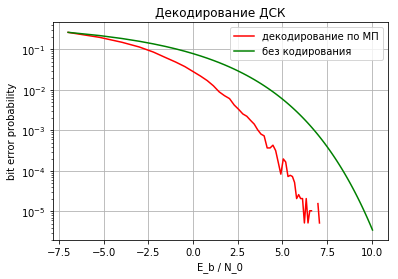

In [176]:
bsc_plot,     = plt.semilogy(x, bsc_probs, 'r', label="декодирование по МП")
nocode_plot, = plt.semilogy(x, probs,    'g', label="без кодирования")
plt.legend(handles=[mp_plot, nocode_plot])
plt.title("Декодирование ДСК")
plt.ylabel("bit error probability")
plt.xlabel("E_b / N_0")
plt.gca().grid(True)
plt.show()

In [177]:
required_bep = 10e-5

def find_required_bep_index(a):
    return (np.abs(np.array(a) - required_bep)).argmin() 

mp_bsc_index = find_required_bep_index(bsc_probs)
nocode_index = find_required_bep_index(probs)

print()
print("E_b / N_0 при декодировании по МП      = {0:.2f} дБ".format(x[mp_bsc_index]))
print("E_b / N_0 при передачи без кодирования = {0:.2f} дБ".format(x[nocode_index]))
print()
print("Энергетический выйгрыш кодирования при ДСК = {0:.2f} дБ".format(x[nocode_index] - x[mp_bsc_index]))


E_b / N_0 при декодировании по МП      = 4.91 дБ
E_b / N_0 при передачи без кодирования = 8.39 дБ

Энергетический выйгрыш кодирования при ДСК = 3.47 дБ


##### 2. Cлучай канала с АБГШ

In [ ]:
def awgn_sigma(val, R):
    return np.sqrt(10. ** (-val / 10) / 2 / R)

def awgn_spoiler(sigma, codes):
    def spoil(i):
        code = codes[i]
        x = 2 * code - 1
        return x + sigma * np.random.randn(code.shape[0])
    return spoil

awgn_probs = [get_error_probability(mp(L_awgn, codes), awgn_spoiler(awgn_sigma(val, 0.4), codes), infos) for val in values]

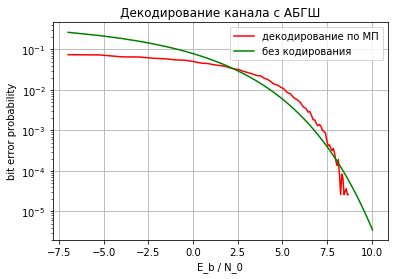

In [168]:
awgn_plot,     = plt.semilogy(x, awgn_probs, 'r', label="декодирование по МП")
nocode_plot, = plt.semilogy(x, probs,    'g', label="без кодирования")
plt.legend(handles=[mp_plot, nocode_plot])
plt.title("Декодирование канала с АБГШ")
plt.ylabel("bit error probability")
plt.xlabel("E_b / N_0")
plt.gca().grid(True)
plt.show()

In [169]:
mp_awgn_index = find_required_bep_index(awgn_probs)

print()
print("E_b / N_0 при декодировании по МП      = {0:.2f} дБ".format(x[mp_awgn_index]))
print("E_b / N_0 при передачи без кодирования = {0:.2f} дБ".format(x[nocode_index]))
print()
print("Энергетический выйгрыш кодирования при канале с АБГШ = {0:.2f} дБ".format(x[nocode_index] - x[mp_awgn_index]))


E_b / N_0 при декодировании по МП      = 8.20 дБ
E_b / N_0 при передачи без кодирования = 8.39 дБ

Энергетический выйгрыш кодирования при канале с АБГШ = 0.19 дБ


### Задача 4.4

In [9]:
m = None
    
def xor(row1, row2):
    global m
    print("{} += {}".format(row1, row2))
    m[row1] = np.mod(m[row1] + m[row2], 2)
    
def swap(row1, row2):
    global m
    print("swap({}, {})".format(row1, row2))
    m[[row1, row2]] = m[[row2, row1]]


#### Приведение к МСФ 

Пребразуем матрицу `table` к МСФ:

In [10]:
m = table.copy()

xor(3, 2)
xor(3, 0)
xor(3, 1)

print()
print(m, "\n")

swap(0, 2)
swap(1, 3)
swap(1, 2)

print("\nПорождающая матрица, приведенная к МСФ:")
print(m)

3 += 2
3 += 0
3 += 1

[[0 1 1 0 0 0 1 1 0 0]
 [0 0 0 1 1 0 1 0 0 1]
 [1 1 1 0 1 1 0 0 0 0]
 [0 0 1 1 0 1 1 1 1 0]] 

swap(0, 2)
swap(1, 3)
swap(1, 2)

Порождающая матрица, приведенная к МСФ:
[[1 1 1 0 1 1 0 0 0 0]
 [0 1 1 0 0 0 1 1 0 0]
 [0 0 1 1 0 1 1 1 1 0]
 [0 0 0 1 1 0 1 0 0 1]]


#### Построение минимальной решетки по порождающей матрице в МСФ

In [11]:
# Узел решетки        
Node = namedtuple("Node", "actives uid edges")   

ids = 0
def new_node(actives):
    global ids
    ids += 1
    return Node(actives, ids - 1, [])
  
def count_label(node):
    return "".join(map(str, node.actives.values()))

In [12]:
# Построим узлы решётки
g = m
begins = np.apply_along_axis(lambda row: np.min(np.flatnonzero(row)), 1, g)
ends   = np.apply_along_axis(lambda row: np.max(np.flatnonzero(row)), 1, g)

# print("Begin:", begins)
# print("End:  ", ends)

ids = 0
layers  = [[new_node(dict())]]
actives = [[]]
for i in range(0, g.shape[1]):
    layer  = []
    active = np.nonzero(np.logical_and(begins <= i, i < ends))[0]
    node_values = gen_permutations(len(active))
    for node_value in node_values:
        layer.append(new_node(dict(zip(active, node_value))))
    
    layers.append(layer)
    actives.append(active + 1)

# print()
# for i, layer in enumerate(layers):
#     print("Layer", i, "symbols", actives[i], "nodes", ", ".join(map(lambda n: "{} : {}".format(n.uid, count_label(n)), layer)))


In [13]:
# Построим ребра решётки
for i in range(len(layers) - 1):
#     print("Layer ", i)
    cur_layer = layers[i]
    nex_layer = layers[i + 1]
    for cur_node in cur_layer:
        for nex_node in nex_layer:
            isymbols = np.zeros(g.shape[0], np.int64) 
            mismatched = False
            for pos in range(len(isymbols)):
                value = cur_node.actives.get(pos)
                if value is None:
                    value = nex_node.actives.get(pos)
                    if value is None:
                        value = 0
                else:
                    nex_value = nex_node.actives.get(pos)
                    if nex_value is not None and nex_value != value:
                        mismatched = True
                        break
                isymbols[pos] = value
            if mismatched:
                continue
            c = np.mod(np.dot(g[:,i], isymbols) , 2)
#             print("{} --{}--> {}".format(cur_node.uid, c, nex_node.uid))
            cur_node.edges.append((c, nex_node))

In [14]:
# Построение графа с помощью утилиты graphviz 
dot = Digraph()
dot.graph_attr['rankdir'] = 'LR'
dot.graph_attr['nodesep'] = '0'
dot.graph_attr['ranksep'] = '1'
dot.graph_attr['splines'] = 'polyline'
for i, layer in enumerate(layers):
    with dot.subgraph(name='cluster_{}'.format(i)) as c:
        c.attr(label='layer #{}\nsymbols {}'.format(i, actives[i]), pencolor='transparent')
        for node in layer:
            label = count_label(node)
            c.node(str(node.uid), label)
            for edge in node.edges:
                dot.edge(str(node.uid), str(edge[1].uid), str(edge[0]))

dot.render('res_spen')  

'res_spen.pdf'

#### Построение решетки по проверочной матрице

In [15]:
# Узел решетки        
Node = namedtuple("Node", "uid edges")   

ids = 0
def new_node():
    global ids
    ids += 1
    return Node(ids - 1, dict())

In [16]:

h = table
h_slices = dict()
n = table.shape[1]
for i in range(1, n + 1):
    h_slices[i] = table[:, 0:i].T

codes = []
for code in gen_permutations(table.shape[1]):
    if not np.any(np.mod(np.dot(h, code), 2)):
        codes.append(code)

In [17]:
ids = 0
layers = [dict() for i in range(len(h_slices) + 1)]
root = new_node()
layers[0][(0,) * table.shape[0]] = root
for code in codes:
    prev_node = root
    for i in range(1, n + 1):
        l = layers[i]
        syndrom = tuple(np.mod(np.dot(code[0:i], h_slices[i]), 2).tolist())
        if syndrom in l:
            node = l[syndrom]
        else:
            node = new_node()
            l[syndrom] = node
        prev_node.edges[code[i - 1]] = node
        prev_node = node

In [19]:
# Построение графа с помощью утилиты graphviz 
dot = Digraph()
dot.graph_attr['rankdir'] = 'LR'
dot.graph_attr['nodesep'] = '0'
dot.graph_attr['ranksep'] = '1.5'
dot.graph_attr['splines'] = 'polyline'
for i, layer in enumerate(layers):
    with dot.subgraph(name='cluster_{}'.format(i)) as c:
        c.attr(label='layer #{}'.format(i), pencolor='transparent')
        for syndrom, node in layer.items():
            lbl = "".join(map(str, syndrom))
            c.node(str(node.uid), lbl)
            for v, nextnode in node.edges.items():
                dot.edge(str(node.uid), str(nextnode.uid), str(v))

dot.render('res_h')

'res_h.pdf'